In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install cyvcf2
# !pip install qqman

In [ ]:
# Import libraries
%pylab inline
import os
import csv
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from cyvcf2 import VCF
# from qqman import qqman

Populating the interactive namespace from numpy and matplotlib


In [ ]:
! wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
! unzip plink_linux_x86_64_20231211.zip
! ./plink

--2024-03-10 16:36:31--  https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.209.224, 52.216.152.158, 52.217.228.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.209.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8953953 (8.5M) [application/zip]
Saving to: ‘plink_linux_x86_64_20231211.zip’

plink_linux_x86_64_ 100%[===================>]   8.54M  23.7MB/s    in 0.4s    

2024-03-10 16:36:32 (23.7 MB/s) - ‘plink_linux_x86_64_20231211.zip’ saved [8953953/8953953]

Archive:  plink_linux_x86_64_20231211.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink <input flag(

In [ ]:
! wget https://s3.amazonaws.com/plink2-assets/alpha5/plink2_linux_x86_64_20240105.zip
! unzip plink2_linux_x86_64_20240105.zip
! ./plink2

--2024-03-10 16:36:33--  https://s3.amazonaws.com/plink2-assets/alpha5/plink2_linux_x86_64_20240105.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.209.224, 52.216.152.158, 52.217.228.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.209.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9266484 (8.8M) [application/zip]
Saving to: ‘plink2_linux_x86_64_20240105.zip’

plink2_linux_x86_64 100%[===================>]   8.84M  44.0MB/s    in 0.2s    

2024-03-10 16:36:33 (44.0 MB/s) - ‘plink2_linux_x86_64_20240105.zip’ saved [9266484/9266484]

Archive:  plink2_linux_x86_64_20240105.zip
  inflating: plink2                  
PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink2 <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink2 --help [flag name(s)...]

Commands include --rm-dup list, --make-bpgen, --export, --

In [ ]:
POP = 'CEU'
POP_VAL = 'GBR'
POP_TEST = 'FIN'
POWER = -0.25
HER = 0.9
NUM_CAUSALS = 100
# PHENO_NUM = 1

In [ ]:
PREFIX = '/content/drive/MyDrive/CSE-284-Final-Project/data'
GENO_TRAIN = f'{PREFIX}/1000g_by_population/{POP}_all'
GENO_VAL = f'{PREFIX}/1000g_by_population/{POP_VAL}_all'
GENO_TEST = f'{PREFIX}/1000g_by_population/{POP_TEST}_all'
PHENO = f'{PREFIX}/1000g_pheno/power={POWER}_her={HER}_num-causals={NUM_CAUSALS}.phen'

In [ ]:
sh = f'''
./plink2 --bfile {GENO_TRAIN} \
         --pheno {PHENO} \
         --glm allow-no-covars \
         --maf 0.05 \
         --out {POP}_gwas
'''

with open('gwas.sh', 'w') as file:
    file.write(sh)
!bash gwas.sh

PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU_gwas.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all
  --glm allow-no-covars
  --maf 0.05
  --out CEU_gwas
  --pheno /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_pheno/power=-0.25_her=0.9_num-causals=100.phen

Start time: Sun Mar 10 16:36:34 2024
12978 MiB RAM detected, ~11739 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
99 samples (50 females, 49 males; 99 founders) loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all.fam.
7657529 variants loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all.bim.
100 quantitative phenotypes loaded.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%

In [ ]:
PHENO_NUM_START = 1
PHENO_NUM_END = 5
combined_prediction_data = []
combined_result_data = []

for PHENO_NUM in range(PHENO_NUM_START, PHENO_NUM_END + 1):

    GLM = f'/content/{POP}_gwas.PHENO{PHENO_NUM}.glm.linear'

    sh = f'''
    ./plink2 \
        --bfile {GENO_TRAIN} \
        --clump-p1 1 \
        --clump-r2 0.1 \
        --clump-kb 250 \
        --clump {GLM} \
        --out {POP}_gwas.PHENO{PHENO_NUM}

    awk 'NR!=1{{print $3}}' {POP}_gwas.PHENO{PHENO_NUM}.clumps > {POP}_gwas.PHENO{PHENO_NUM}.valid.snp
    cat {POP}_gwas.PHENO{PHENO_NUM}.clumps | awk '{{print $3 "\t" $4}}' > {POP}_gwas.PHENO{PHENO_NUM}.pvals
    '''

    with open('clump.sh', 'w') as file:
        file.write(sh)
    !bash clump.sh

    GLM = f'/content/{POP}_gwas.PHENO{PHENO_NUM}.glm.linear'
    PVALS = f'/content/{POP}_gwas.PHENO{PHENO_NUM}.pvals'
    VAL = f'/content/{POP}_gwas.PHENO{PHENO_NUM}.valid.snp'

    sh = f'''
    echo "0.000001 0 0.000001" > range_list
    echo "0.00001 0 0.00001" >> range_list
    echo "0.0001 0 0.0001" >> range_list
    echo "0.001 0 0.001" >> range_list
    echo "0.05 0 0.05" >> range_list
    echo "0.1 0 0.1" >> range_list

    ./plink2 \
    --bfile {GENO_TRAIN} \
    --score {GLM} 3 7 12 header cols=+scoresums\
    --q-score-range range_list {PVALS} \
    --extract {VAL} \
    --out {POP}_PHENO{PHENO_NUM}_train

    ./plink2 \
    --bfile {GENO_VAL} \
    --score {GLM} 3 7 12 header cols=+scoresums\
    --q-score-range range_list {PVALS} \
    --extract {VAL} \
    --out {POP}_PHENO{PHENO_NUM}_val

    ./plink2 \
    --bfile {GENO_TEST} \
    --score {GLM} 3 7 12 header cols=+scoresums\
    --q-score-range range_list {PVALS} \
    --extract {VAL} \
    --out {POP}_PHENO{PHENO_NUM}_test
    '''

    with open('score.sh', 'w') as file:
      file.write(sh)
    !bash score.sh

    pval_list = ["0.000001", "0.00001", "0.0001", "0.001", "0.05", "0.1"]
    best_pval_idx = 0
    train_scores = []
    val_scores = []
    test_scores = []
    train_score = 0
    val_score = 0
    test_score = 0

    print("Training: ")
    for pval in pval_list:
        score_file = f'{POP}_PHENO{PHENO_NUM}_train.{pval}.sscore'
        if os.path.isfile(score_file) == False:
          continue
        prs = pd.read_csv(score_file, delim_whitespace=True)
        phen = pd.read_csv(f'{PHENO}',
                      delim_whitespace=True, usecols=[0, 1, PHENO_NUM + 1], names=["FID","IID","phen"])
        d = pd.merge(prs, phen, on=["IID"])
        score = scipy.stats.pearsonr(d["phen"], d["SCORE1_SUM"])[0] ** 2
        train_scores.append(score)
        print("pval=%s, R2=%s"%(pval, score))
    train_score = np.nanmax(train_scores)

    print("Validation: ")
    for pval in pval_list:
        score_file = f'{POP}_PHENO{PHENO_NUM}_val.{pval}.sscore'
        if os.path.isfile(score_file) == False:
          val_scores.append(-1)
          continue
        prs = pd.read_csv(score_file, delim_whitespace=True)
        phen = pd.read_csv(f'{PHENO}',
                      delim_whitespace=True, usecols=[0, 1, PHENO_NUM + 1], names=["FID","IID","phen"])
        d = pd.merge(prs, phen, on=["IID"])
        score = scipy.stats.pearsonr(d["phen"], d["SCORE1_SUM"])[0] ** 2
        val_scores.append(score)
        print("pval=%s, R2=%s"%(pval, score))
    val_score = np.nanmax(val_scores)
    best_pval_idx = val_scores.index(val_score)
    print("Best: ", pval_list[best_pval_idx], val_score)

    print("Testing: ")
    best_pval = pval_list[best_pval_idx]
    prs = pd.read_csv(f'{POP}_PHENO{PHENO_NUM}_test.{best_pval}.sscore', delim_whitespace=True)
    phen = pd.read_csv(f'{PHENO}',
                      delim_whitespace=True, usecols=[0, 1, PHENO_NUM + 1], names=["FID","IID","phen"])
    d = pd.merge(prs, phen, on=["IID"])
    test_score = scipy.stats.pearsonr(d["phen"], d["SCORE1_SUM"])[0] ** 2
    print("pval=%s, R2=%s"%(best_pval, test_score))
    predict_df = d[['IID', 'SCORE1_SUM', 'phen']].copy()
    predict_df.rename(columns={'IID': 'IID', 'SCORE1_SUM': 'predict', 'phen': 'actual'}, inplace=True)
    predict_df["pheno_num"] = PHENO_NUM
    combined_prediction_data.append(predict_df)

    result_dict = {
        "population/superpopulation": POP,
        "power": POWER,
        "her": HER,
        "num_causals": NUM_CAUSALS,
        "pheno_num": PHENO_NUM,
        "train": train_score,
        "val": val_score,
        "test": test_score
    }
    combined_result_data.append(result_dict)

combined_prediction_df = pd.concat(combined_prediction_data, ignore_index=True)
combined_result_df = pd.DataFrame(combined_result_data)

# Write combined prediction data to file
combined_prediction_file = f'combined_predict_{POP}_power={POWER}_her={HER}_num-causals={NUM_CAUSALS}_pheno={PHENO_NUM_START}-{PHENO_NUM_END}.csv'
combined_prediction_df.to_csv(combined_prediction_file, index=False)
print("Combined prediction data has been written to:", combined_prediction_file)

# Write combined result data to file
combined_result_file = f'combined_result_{POP}_power={POWER}_her={HER}_num-causals={NUM_CAUSALS}_pheno={PHENO_NUM_START}-{PHENO_NUM_END}.csv'
combined_result_df.to_csv(combined_result_file, index=False)
print("Combined result data has been written to:", combined_result_file)


PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU_gwas.PHENO1.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all
  --clump /content/CEU_gwas.PHENO1.glm.linear
  --clump-kb 250
  --clump-p1 1
  --clump-r2 0.1
  --out CEU_gwas.PHENO1

Start time: Sun Mar 10 17:46:09 2024
12978 MiB RAM detected, ~11397 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
99 samples (50 females, 49 males; 99 founders) loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all.fam.
7657529 variants loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all.bim.
Note: No phenotype data present.
--clump: 174734 clumps formed from 6067679 index candidates.  
Results written to CEU_gwas.PHENO1.clumps .
End time: Sun Mar 10 17:46:46 2024
PLINK

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


pval=0.00001, R2=0.666738876527012
pval=0.0001, R2=0.9528116667615566
pval=0.001, R2=0.990548338802786
pval=0.05, R2=0.9980341419531291
pval=0.1, R2=0.9982120668926812
Validation: 
pval=0.000001, R2=nan
pval=0.00001, R2=0.0029872297333194565
pval=0.0001, R2=0.026228628576148195


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


pval=0.001, R2=0.013220933827399185
pval=0.05, R2=0.013180582650294233
pval=0.1, R2=0.00694312751727047
Best:  0.0001 0.026228628576148195
Testing: 
pval=0.0001, R2=0.0030594145292613204
PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU_gwas.PHENO4.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all
  --clump /content/CEU_gwas.PHENO4.glm.linear
  --clump-kb 250
  --clump-p1 1
  --clump-r2 0.1
  --out CEU_gwas.PHENO4

Start time: Sun Mar 10 17:49:13 2024
12978 MiB RAM detected, ~11975 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
99 samples (50 females, 49 males; 99 founders) loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all.fam.
7657529 variants loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_al

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


pval=0.00001, R2=0.6751153017600755
pval=0.0001, R2=0.9563589333394112
pval=0.001, R2=0.9904329233945551
pval=0.05, R2=0.9984428982593454
pval=0.1, R2=0.998711664473381
Validation: 
pval=0.000001, R2=nan
pval=0.00001, R2=0.01683662200838693


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


pval=0.0001, R2=0.02598402976650764
pval=0.001, R2=0.00024295178644607042
pval=0.05, R2=0.009701503784737038
pval=0.1, R2=0.008082280677088072
Best:  0.0001 0.02598402976650764
Testing: 
pval=0.0001, R2=0.009169169516336268
PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU_gwas.PHENO5.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all
  --clump /content/CEU_gwas.PHENO5.glm.linear
  --clump-kb 250
  --clump-p1 1
  --clump-r2 0.1
  --out CEU_gwas.PHENO5

Start time: Sun Mar 10 17:50:08 2024
12978 MiB RAM detected, ~11975 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
99 samples (50 females, 49 males; 99 founders) loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all.fam.
7657529 variants loaded from
/content/drive/MyDrive/CSE-284-Final-Pr

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


pval=0.00001, R2=0.7782745621541792
pval=0.0001, R2=0.9517847206090025
pval=0.001, R2=0.9910606791921667
pval=0.05, R2=0.9987301666557851
pval=0.1, R2=0.9988608517952443
Validation: 
pval=0.000001, R2=nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


pval=0.00001, R2=0.001417717174867031
pval=0.0001, R2=0.003459284284356999
pval=0.001, R2=0.010515056807794318
pval=0.05, R2=0.008321690983923578
pval=0.1, R2=0.005075134541341679
Best:  0.001 0.010515056807794318
Testing: 
pval=0.001, R2=0.0007412048726667846
Combined prediction data has been written to: combined_predict_CEU_power=-0.25_her=0.9_num-causals=100_pheno=1-5.csv
Combined result data has been written to: combined_result_CEU_power=-0.25_her=0.9_num-causals=100_pheno=1-5.csv


In [ ]:
print(combined_result_df)
print(combined_prediction_df)

  population/superpopulation  power  her  num_causals  pheno_num     train  \
0                        CEU  -0.25  0.9          100          1  0.998281   
1                        CEU  -0.25  0.9          100          2  0.998775   
2                        CEU  -0.25  0.9          100          3  0.998212   
3                        CEU  -0.25  0.9          100          4  0.998712   
4                        CEU  -0.25  0.9          100          5  0.998861   

        val      test  
0  0.023926  0.000408  
1  0.029672  0.007398  
2  0.026229  0.003059  
3  0.025984  0.009169  
4  0.010515  0.000741  
         IID   predict    actual  pheno_num
0    HG00171  0.108795  0.969237          1
1    HG00173  2.823370 -0.912872          1
2    HG00174  2.154870 -1.625063          1
3    HG00176  0.766328 -1.421495          1
4    HG00177  3.108050  1.525236          1
..       ...       ...       ...        ...
490  HG00380  8.925880 -0.579737          5
491  HG00381  1.898800  0.050008   

In [ ]:
# !mv combined* /content/drive/MyDrive/CSE-284-Final-Project/data/CT/
# !find . -maxdepth 1 -type f -not \( -name 'plink*' -o -name 'plink2*' \) -exec rm -f {} +

rm: cannot remove 'drive': Is a directory
rm: cannot remove 'sample_data': Is a directory


In [ ]:
sh = f'''
./plink \
    --bfile {GENO_TRAIN} \
    --score {GLM} 3 7 12 header sum\
    --q-score-range range_list {PVALS} \
    --extract {VAL} \
    --out {POP}_PHENO{PHENO_NUM}_train
'''

with open('test_score.sh', 'w') as file:
  file.write(sh)
!bash test_score.sh

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU_PHENO5_train.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all
  --extract /content/CEU_gwas.PHENO5.valid.snp
  --out CEU_PHENO5_train
  --q-score-range range_list /content/CEU_gwas.PHENO5.pvals
  --score /content/CEU_gwas.PHENO5.glm.linear 3 7 12 header sum

12978 MB RAM detected; reserving 6489 MB for main workspace.
7657529 variants loaded from .bim file.
99 people (49 males, 50 females) loaded from .fam.
--extract: 174803 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 99 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%

In [ ]:
! head -n 5 CEU_PHENO5_train.0.001.profile

      FID       IID  PHENO    CNT   CNT2 SCORESUM
  EUR_CEU   NA06984     -9   1846    401  73.0098
  EUR_CEU   NA06985     -9   1846    432 -79.7015
  EUR_CEU   NA06986     -9   1846    392   74.257
  EUR_CEU   NA06989     -9   1846    463  149.746


In [ ]:
sh = f'''
./plink2 \
    --bfile {GENO_TRAIN} \
    --score {GLM} 3 7 12 header cols=+scoresums\
    --q-score-range range_list {PVALS} \
    --extract {VAL} \
    --out {POP}_PHENO{PHENO_NUM}_train
'''

with open('test_score.sh', 'w') as file:
  file.write(sh)
!bash test_score.sh

PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU_PHENO5_train.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all
  --extract /content/CEU_gwas.PHENO5.valid.snp
  --out CEU_PHENO5_train
  --q-score-range range_list /content/CEU_gwas.PHENO5.pvals
  --score /content/CEU_gwas.PHENO5.glm.linear 3 7 12 header cols=+scoresums

Start time: Sun Mar 10 17:11:15 2024
12978 MiB RAM detected, ~11421 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
99 samples (50 females, 49 males; 99 founders) loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all.fam.
7657529 variants loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_population/CEU_all.bim.
Note: No phenotype data present.
--extract: 174803 variants remaining.
Calculating allele 

In [ ]:
! head -n 5 CEU_PHENO5_val.0.000001.sscore

#FID	IID	ALLELE_CT	NAMED_ALLELE_DOSAGE_SUM	SCORE1_AVG	SCORE1_SUM
EUR_GBR	HG00096	0	0	nan	0
EUR_GBR	HG00097	0	0	nan	0
EUR_GBR	HG00099	0	0	nan	0
EUR_GBR	HG00100	0	0	nan	0


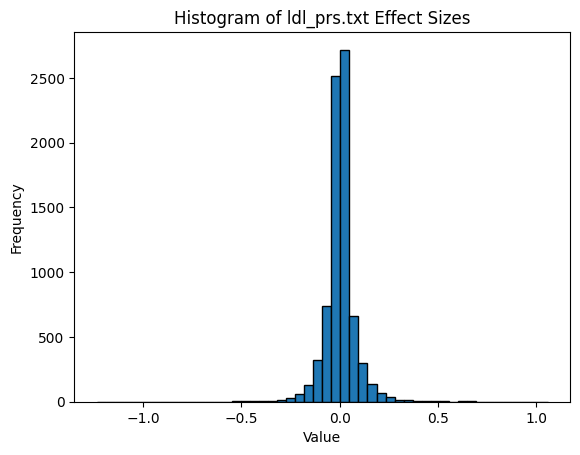

In [ ]:
import matplotlib.pyplot as plt

# Path to your data file
file_path = "/content/drive/MyDrive/CSE-284-Final-Project/data/test_data/ldl_prs.txt"

# Initialize a list to store the values from the third column
values = []

# Open the file and read the lines
with open(file_path, 'r') as file:
    for line in file:
        # Split each line into parts based on whitespace
        parts = line.strip().split()

        # Convert the third column value to float and add it to the list
        if len(parts) > 2:  # To ensure there's a third column
            try:
                value = float(parts[2])
                values.append(value)
            except ValueError:
                # Handle the case where conversion to float fails
                print(f"Skipping line due to conversion error: {line.strip()}")

# Plotting the histogram
# plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(values, bins=50, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of ldl_prs.txt Effect Sizes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
GLM = f'/content/{POP}_gwas.PHENO{PHENO_NUM}.glm.linear'

sh = f'''
./plink2 \
    --bfile {GENO_TRAIN} \
    --clump-p1 1 \
    --clump-r2 0.1 \
    --clump-kb 250 \
    --clump {GLM} \
    --out {POP}_gwas.PHENO{PHENO_NUM}

awk 'NR!=1{{print $3}}' {POP}_gwas.PHENO{PHENO_NUM}.clumps > {POP}_gwas.PHENO{PHENO_NUM}.valid.snp
cat {POP}_gwas.PHENO{PHENO_NUM}.clumps | awk '{{print $3 "\t" $4}}' > {POP}_gwas.PHENO{PHENO_NUM}.pvals
'''

with open('clump.sh', 'w') as file:
    file.write(sh)
!bash clump.sh

PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EUR_gwas.PHENO1.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_superpopulation/EUR_train
  --clump /content/EUR_gwas.PHENO1.glm.linear
  --clump-kb 250
  --clump-p1 1
  --clump-r2 0.1
  --out EUR_gwas.PHENO1

Start time: Sat Mar  9 18:44:07 2024
12978 MiB RAM detected, ~11529 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
403 samples (211 females, 192 males; 403 founders) loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_superpopulation/EUR_train.fam.
7667132 variants loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_superpopulation/EUR_train.bim.
Note: No phenotype data present.
--clump: 191670 clumps formed from 6038406 index candidates.  
Results written to EUR_gwas.PHENO1.clumps .
End time: Sat M

In [ ]:
PREFIX = '/content/drive/MyDrive/CSE-284-Final-Project/data'
GENO_TRAIN = f'{PREFIX}/1000g_by_superpopulation/{POP}_train'
GENO_VAL = f'{PREFIX}/1000g_by_superpopulation/{POP}_val'
GENO_TEST = f'{PREFIX}/1000g_by_superpopulation/{POP}_test'
GLM = f'/content/{POP}_gwas.PHENO{PHENO_NUM}.glm.linear'
PVALS = f'/content/{POP}_gwas.PHENO{PHENO_NUM}.pvals'
VAL = f'/content/{POP}_gwas.PHENO{PHENO_NUM}.valid.snp'

sh = f'''
echo "0.000001 0 0.000001" > range_list
echo "0.00001 0 0.00001" >> range_list
echo "0.0001 0 0.0001" >> range_list
echo "0.001 0 0.001" >> range_list
echo "0.05 0 0.05" >> range_list
echo "0.1 0 0.1" >> range_list

./plink \
    --bfile {GENO_TRAIN} \
    --score {GLM} 3 7 12 header sum\
    --q-score-range range_list {PVALS} \
    --extract {VAL} \
    --out {POP}_PHENO{PHENO_NUM}_train

./plink \
    --bfile {GENO_VAL} \
    --score {GLM} 3 7 12 header sum\
    --q-score-range range_list {PVALS} \
    --extract {VAL} \
    --out {POP}_PHENO{PHENO_NUM}_val

./plink \
    --bfile {GENO_TEST} \
    --score {GLM} 3 7 12 header sum\
    --q-score-range range_list {PVALS} \
    --extract {VAL} \
    --out {POP}_PHENO{PHENO_NUM}_test
'''

with open('score.sh', 'w') as file:
    file.write(sh)
!bash score.sh

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EUR_PHENO1_train.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_superpopulation/EUR_train
  --extract /content/EUR_gwas.PHENO1.valid.snp
  --out EUR_PHENO1_train
  --q-score-range range_list /content/EUR_gwas.PHENO1.pvals
  --score /content/EUR_gwas.PHENO1.glm.linear 3 7 12 header sum

12978 MB RAM detected; reserving 6489 MB for main workspace.
7667132 variants loaded from .bim file.
403 people (192 males, 211 females) loaded from .fam.
--extract: 191670 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 403 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%

In [ ]:
pval_list = ["0.000001", "0.00001", "0.0001", "0.001", "0.05", "0.1"]
best_pval_idx = 0
train_scores = []
val_scores = []
test_scores = []
train_score = 0
val_score = 0
test_score = 0

In [ ]:
print("Train: ")
for pval in pval_list:
    if os.path.isfile(f'{POP}_PHENO{PHENO_NUM}_train.{pval}.profile') == False:
      continue
    prs = pd.read_csv(f'{POP}_PHENO{PHENO_NUM}_train.{pval}.profile', delim_whitespace=True)
    phen = pd.read_csv(f'{PHENO}',
                   delim_whitespace=True, usecols=[0, 1, PHENO_NUM + 1], names=["FID","IID","phen"])
    d = pd.merge(prs, phen, on=["IID"])
    train_scores.append(scipy.stats.pearsonr(d["phen"], d["SCORESUM"])[0] ** 2)
    print("pval=%s, R2=%s"%(pval, scipy.stats.pearsonr(d["phen"], d["SCORESUM"])[0] ** 2))
train_score = max(train_scores)

Train: 
pval=0.000001, R2=0.362155439197106
pval=0.00001, R2=0.5607026110463355
pval=0.0001, R2=0.8549580767748133
pval=0.001, R2=0.965400283226466
pval=0.05, R2=0.993264172641837
pval=0.1, R2=0.9933536774177879


In [ ]:
print("Validation: ")
for pval in pval_list:
    if os.path.isfile(f'{POP}_PHENO{PHENO_NUM}_val.{pval}.profile') == False:
      val_scores.append(-1)
      continue
    prs = pd.read_csv(f'{POP}_PHENO{PHENO_NUM}_val.{pval}.profile', delim_whitespace=True)
    phen = pd.read_csv(f'{PHENO}',
                   delim_whitespace=True, usecols=[0, 1, PHENO_NUM + 1], names=["FID","IID","phen"])
    d = pd.merge(prs, phen, on=["IID"])
    val_scores.append(scipy.stats.pearsonr(d["phen"], d["SCORESUM"])[0] ** 2)
    print("pval=%s, R2=%s"%(pval, scipy.stats.pearsonr(d["phen"], d["SCORESUM"])[0] ** 2))
val_score = max(val_scores)
best_pval_idx = val_scores.index(val_score)
print("Best: ", pval_list[best_pval_idx], val_score)

Validation: 
pval=0.000001, R2=0.04080319506650156
pval=0.00001, R2=0.10305716758358899
pval=0.0001, R2=0.06630509279913087
pval=0.001, R2=0.0302067114028334
pval=0.05, R2=0.05148496258572893
pval=0.1, R2=0.047552705201222026
Best:  0.00001 0.10305716758358899


In [ ]:
best_pval = pval_list[best_pval_idx]
prs = pd.read_csv(f'{POP}_PHENO{PHENO_NUM}_test.{best_pval}.profile', delim_whitespace=True)
phen = pd.read_csv(f'{PHENO}',
                   delim_whitespace=True, usecols=[0, 1, PHENO_NUM + 1], names=["FID","IID","phen"])
d = pd.merge(prs, phen, on=["IID"])
# Select and rename the required columns
output_df = d[['IID', 'SCORESUM', 'phen']].copy()
output_df.rename(columns={'IID': 'IID', 'SCORESUM': 'predict', 'phen': 'actual'}, inplace=True)
result_file_name = f'predict_{POP}_power={POWER}_her={HER}_num-causals={NUM_CAUSALS}_phen={PHENO_NUM}.csv'
output_df.to_csv(result_file_name, index=False)
print("The prediction file has been created:", result_file_name)
print("Result of testing: ")
print("pval=%s, R2=%s"%(best_pval, scipy.stats.pearsonr(d["phen"], d["SCORESUM"])[0] ** 2))

The prediction file has been created: predict_EUR_power=-0.25_her=0.9_num-causals=100_phen=1.csv
Result of testing: 
pval=0.00001, R2=0.057351530155317826


In [ ]:
data = [
    {"population/superpopulation": "EUR", "power": POWER, "her": HER, "num_causals": NUM_CAUSALS, "train": train_score, "val": val_score, "test": test_score},
]

file_name = f'result_{POP}_power={POWER}_her={HER}_num-causals={NUM_CAUSALS}_phen={PHENO_NUM}.csv'

fieldnames = ["population/superpopulation", "power", "her", "num_causals", "train", "val", "test"]

with open(file_name, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for row in data:
        writer.writerow(row)
print(f"Result data has been written to {file_name}")


Result data has been written to result_EUR_power=-0.25_her=0.9_num-causals=100_phen=1.csv


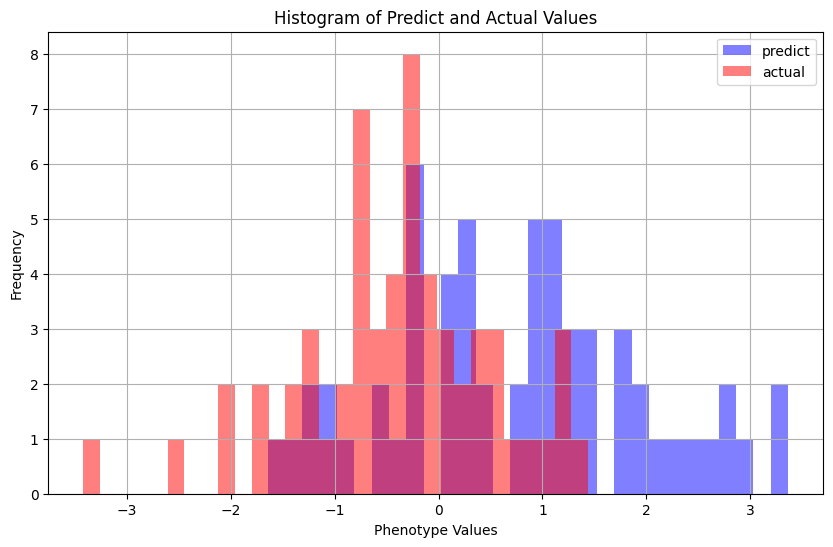

In [ ]:
df = pd.read_csv(result_file_name)

plt.figure(figsize=(10, 6))
plt.hist(df['predict'], bins=30, color='blue', alpha=0.5, label='predict')
plt.hist(df['actual'], bins=30, color='red', alpha=0.5, label='actual')

plt.title('Histogram of Predict and Actual Values')
plt.xlabel('Phenotype Values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

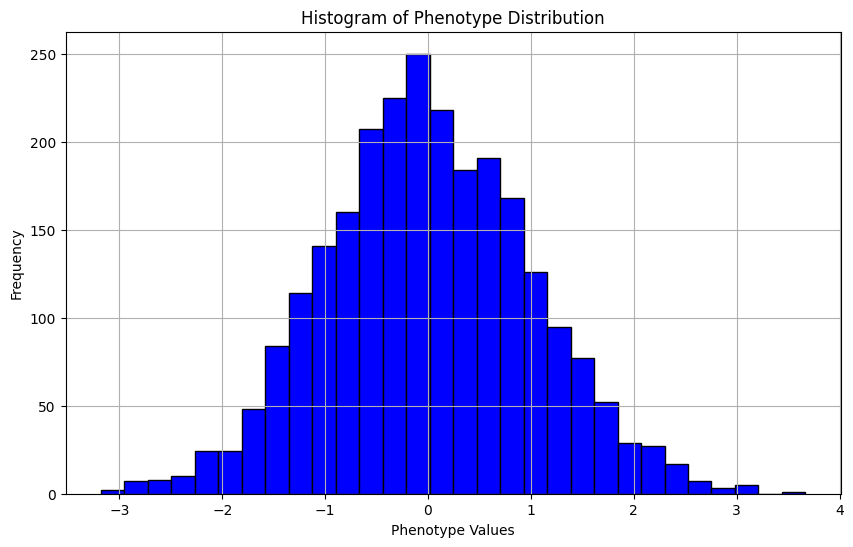

In [ ]:
data = pd.read_csv(f'{PHENO}', sep=" ", header=None)
phenotype_values = data.iloc[:, PHENO_NUM + 5]

plt.figure(figsize=(10, 6))
plt.hist(phenotype_values, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Phenotype Distribution')
plt.xlabel('Phenotype Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
!head -n 5 /content/drive/MyDrive/CSE-284-Final-Project/data/test_data/kgvcf_ldl.phen

HG00743	HG00743	-3.163135897264358
NA19759	NA19759	-3.0043490778178326
NA18979	NA18979	-2.997470340567332
NA19777	NA19777	-2.766950889364885
HG02019	HG02019	-2.726289258242937


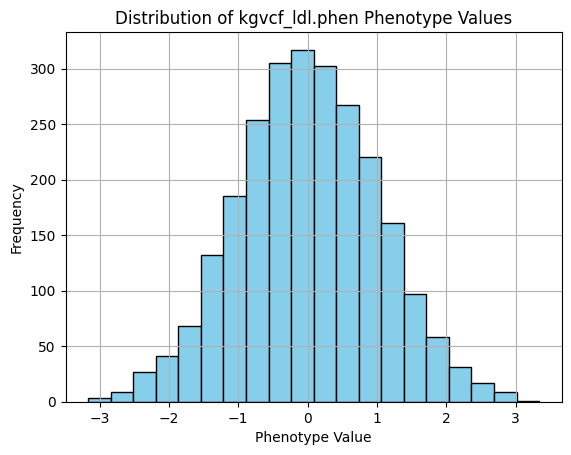

In [ ]:
import matplotlib.pyplot as plt

# Read the third column values from the file
values = []
with open('/content/drive/MyDrive/CSE-284-Final-Project/data/test_data/kgvcf_ldl.phen', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            try:
                value = float(parts[2])
                values.append(value)
            except ValueError:
                pass  # Ignore lines with invalid values

# Plot histogram
plt.hist(values, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Phenotype Value')
plt.ylabel('Frequency')
plt.title('Distribution of kgvcf_ldl.phen Phenotype Values')
plt.grid(True)
plt.show()


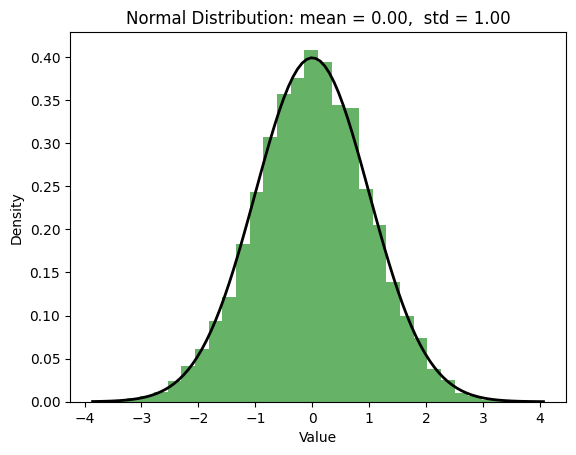

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the distribution
mean = 0
variance = 1
std_deviation = np.sqrt(variance)
num_samples = 10000

# Generate random samples from a normal distribution
samples = np.random.normal(mean, std_deviation, num_samples)

# Plot histogram
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')

# Overlay the probability density function
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = (1 / (np.sqrt(2 * np.pi) * std_deviation)) * np.exp(-0.5 * ((x - mean) / std_deviation) ** 2)
plt.plot(x, p, 'k', linewidth=2)

title = "Normal Distribution: mean = %.2f,  std = %.2f" % (mean, std_deviation)
plt.title(title)
plt.xlabel('Value')
plt.ylabel('Density')

plt.show()


In [ ]:
!head -n 5 $PHENO

EUR_GBR HG00096 0.463342 0.585359 0.786797 -0.149097 -1.710485 0.017377 -1.076481 -0.261652 0.053231 0.670270 1.178590 -0.075979 -0.564056 -0.620686 -0.813107 -0.811549 -0.672803 -0.708367 -0.872261 0.117702 -0.222223 -0.355062 -0.329043 -0.247987 0.363967 0.264624 -0.546407 -0.742473 1.274714 -0.483934 0.295253 0.555980 0.777909 0.209575 0.648624 0.750209 -0.285529 1.525040 0.825904 -0.523525 0.221698 0.083172 -0.522321 0.558898 0.471289 1.500407 0.621698 1.185627 0.208074 0.331378 0.284803 -0.635894 -0.139794 -0.109584 -0.121049 -0.771240 -0.994922 -0.532152 0.265031 6.310163 -0.182172 0.883123 0.208097 0.252357 0.813675 -0.974714 -0.299637 0.694219 -0.133241 0.308804 0.224790 0.217472 1.220524 0.250450 0.523614 -0.085890 -1.463491 -0.509834 1.037900 -0.196927 -0.636438 -0.592436 0.050554 0.027562 0.238507 0.417381 1.052831 0.587407 -0.042816 0.448250 1.049520 0.141203 -0.167560 -0.011012 -2.367094 -0.395206 0.739904 -0.560767 -0.412144 -0.592582
EUR_GBR HG00097 0.218992 -0.125842 0.

In [ ]:
# sh = '''

# PREFIX=/content/drive/MyDrive/CSE-284-Final-Project/data

# GENO=${PREFIX}/1000g_by_superpopulation/EUR_train

# ./plink2 --bfile $GENO \
#          --pca 3 \
#          --out EUR_gwas
# '''
# with open('pca.sh', 'w') as file:
#     file.write(sh)

# # Run the script
# !bash pca.sh

In [ ]:
!head -n 5 EUR_gwas.PHENO1.clumps
!head -n 5 EUR_gwas.PHENO1.valid.snp
!head -n 5 EUR_gwas.PHENO1.pvals

In [ ]:
!head -n 10 /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_pheno/power=-0.25_her=0.1_num-causals=1.phen
!head -n 30 /content/EUR_PHENO1_val.0.000001.profile

In [ ]:
!head -n 10 /content/EUR_gwas.PHENO1.glm.linear
!head -n 10 /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_superpopulation/EUR_val.bim
# 5847346 --score file entries were skipped due to missing variant IDs.
!head -n 10 EUR_PHENO1_val.sscore.vars

#CHROM	POS	ID	REF	ALT	PROVISIONAL_REF?	A1	OMITTED	A1_FREQ	TEST	OBS_CT	BETA	SE	T_STAT	P	ERRCODE
1	11008	1:11008	C	G	Y	G	C	0.0868486	ADD	403	0.0737329	0.121668	0.60602	0.544844	.
1	11012	1:11012	C	G	Y	G	C	0.0868486	ADD	403	0.0737329	0.121668	0.60602	0.544844	.
1	13110	1:13110	G	A	Y	A	G	0.0620347	ADD	403	-0.102062	0.146873	-0.694897	0.487522	.
1	13116	1:13116	T	G	Y	G	T	0.19727	ADD	403	-0.123808	0.0870264	-1.42264	0.155617	.
1	13118	1:13118	A	G	Y	G	A	0.19727	ADD	403	-0.123808	0.0870264	-1.42264	0.155617	.
1	13273	1:13273	G	C	Y	C	G	0.133995	ADD	403	-0.124524	0.101732	-1.22404	0.221657	.
1	14464	1:14464	A	T	Y	T	A	0.187345	ADD	403	0.186968	0.0904415	2.06728	0.0393489	.
1	14599	1:14599	T	A	Y	A	T	0.163772	ADD	403	0.0291478	0.0988597	0.29484	0.768269	.
1	14604	1:14604	A	G	Y	G	A	0.163772	ADD	403	0.0291478	0.0988597	0.29484	0.768269	.
1	1:11008	0	11008	G	C
1	1:11012	0	11012	G	C
1	1:13110	0	13110	A	G
1	1:13116	0	13116	G	T
1	1:13118	0	13118	G	A
1	1:13273	0	13273	C	G
1	1:14464	0	14464	T	A
1	1:14599	0

In [ ]:
# ./plink2 \
#     --bfile $GENO_VAL \
#     --score $GLM 3 7 12 header list-variants\
#     --q-score-range range_list $PVALS \
#     --extract $VAL \
#     --out EUR_PHENO1_val

In [ ]:
sh = '''

PREFIX=/content/drive/MyDrive/CSE-284-Final-Project/data
GENO_TRAIN=${PREFIX}/1000g_by_superpopulation/EUR_train
GLM=/content/EUR_gwas.PHENO1.glm.linear
PVALS=/content/EUR_gwas.PHENO1.pvals
VAL=/content/EUR_gwas.PHENO1.valid.snp

./plink \
    --bfile $GENO_TRAIN \
    --score $GLM 3 7 12 header sum\
    --q-score-range range_list $PVALS \
    --extract $VAL \
    --out EUR_PHENO1_train
'''
with open('test.sh', 'w') as file:
    file.write(sh)
!bash test.sh

In [ ]:
sh = '''

PREFIX=/content/drive/MyDrive/CSE-284-Final-Project/data
GENO_TEST=${PREFIX}/1000g_by_superpopulation/EUR_test
GLM=/content/EUR_gwas.PHENO1.glm.linear
PVALS=/content/EUR_gwas.PHENO1.pvals
VAL=/content/EUR_gwas.PHENO1.valid.snp

./plink \
    --bfile $GENO_TEST \
    --score $GLM 3 7 12 header sum\
    --q-score-range range_list $PVALS \
    --extract $VAL \
    --out EUR_PHENO1_test
'''
with open('test.sh', 'w') as file:
    file.write(sh)
!bash test.sh